In [38]:
from main3 import AudioStream
%matplotlib inline
import matplotlib.pyplot as plt
import whisper
import torch
import numpy as np
from whisper.tokenizer import get_tokenizer
from whisper import audio

In [39]:
data = AudioStream.from_file("/tmp/output.wav")[0].audio()
model = whisper.load_model("tiny")
tokenizer = get_tokenizer(model.is_multilingual, language='ja')

In [40]:
@torch.no_grad()
def transcribe(model, data, **kwargs):
    language = kwargs['language']
    tokenizer = get_tokenizer(model.is_multilingual, language=kwargs['language'] if 'language' in kwargs else 'en')
    batches = 2
    beams = 1
    segments = []
    overlap = 15
    left = 30 - overlap
    for i in range(0, data.shape[0], left * 16000 * batches):
        x = data[i:i+left * 16000 * batches + overlap * 16000]
        mel = audio.log_mel_spectrogram(x)
        mels = []
        for k in range(batches):
            chunk = mel[:, k * left*100: k * left*100 + 3000]
            if chunk.shape[-1] == 0: break
            if chunk.shape[-1] < 3000: chunk = audio.pad_or_trim(chunk, audio.N_FRAMES)
            mels.append(chunk.unsqueeze(0))
        mels = torch.concat(mels, dim=0)

        initial = [*tokenizer.sot_sequence]
        tokens = torch.tensor(initial).repeat(mels.shape[0]*beams, 1)
        audio_features = model.encoder(mels).repeat_interleave(beams, dim=0)
        print(tokens.shape)
        next_tokens = tokens
        logitsc = torch.tensor([])
        kv_cache, hooks = model.install_kv_cache_hooks()
        while not (tokens[:, -1] == tokenizer.eot).all() and tokens.shape[-1] < 90:
            logits = model.decoder(next_tokens, audio_features, kv_cache=kv_cache)[:, -1:, ]
            logitsc = torch.concat([logitsc, logits[:, :, :tokenizer.timestamp_begin-1].detach()], dim=-2)
            logits[:, :, tokenizer.timestamp_begin+1: tokenizer.timestamp_begin + int(28 // 0.02)] = -np.inf
            next_tokens = logits.argmax(-1)
            next_tokens[tokens[:, -1] == tokenizer.eot] = tokenizer.eot
            tokens = torch.concat([tokens, next_tokens], dim=-1)
        for t in tokens.tolist():
            print(tokenizer.decode_with_timestamps(t))
        print(tokens.shape, logitsc.shape)
        for h in hooks: h.remove()
        kv_cache.clear()
        if (i//(left * 16000 * batches)) >= 1:
            s = [batches-1, tokens.shape[-1]-len(initial), tokens.shape[-1]-len(initial), tokenizer.timestamp_begin-1]
            logitsc, logitscs = logitsc[:-1].unsqueeze(-2).expand(*s), logitsc[1:].unsqueeze(-3).expand(*s)
            sm = (logitsc.softmax(-1) * -logitscs.log_softmax(-1)).sum(-1)
            return tokens.detach(), sm.detach()

torch.Size([2, 3])
<|startoftranscript|><|ja|><|transcribe|><|0.00|>(音楽), アウディブー。 ようじょ選気、中、フィリブスウニです。 前辺。 カルロ前、ちょ。 労毒、山崎県たろう。 山の目具に。 発行、 岡武式内者、カドカは。 本作品では
<|startoftranscript|><|ja|><|transcribe|><|notimestamps|>カルロゼンちょロードく山崎県たろう サノメグミはっこ 岡武式会社かどかは本作品では今日では複敵説とされる国や表現がありますが作品のオリジナリティを尊重するためそのまま収録しましたご�
torch.Size([2, 90]) torch.Size([2, 87, 50363])
torch.Size([2, 3])
<|startoftranscript|><|ja|><|transcribe|><|0.00|>表現がありますが、作品のオリジナリティを尊重するため、そのまま収録しました。ご両聖ください。 第0勝プロローグ。 統一歳、1927年、7月25日、テート。 英語を必要とする時代は引け切だという、 例えば、
<|startoftranscript|><|ja|><|transcribe|><|0.00|>統一歳、1927年、7年、7月25日、テート。 英語を必要とする時代はひげきだという、例えば、知生の脳心、男性の感言うとまで評価された想像とくは絵決であった。 その英語電話、なるほど強い記はまり
torch.Size([2, 90]) torch.Size([2, 87, 50363])
tensor([50364, 17571,  9581,  5142, 37020,  5142,  1231, 11914, 30246,  2972,
        18743, 12376, 14655, 26719, 12376, 22985, 26760,  5998,  1530,   232,
        12624, 22570, 49983,  1231, 20564,  2889,  2889,  2129,   236, 43777,
        44499,  1543,  9991,   940,    94,  8171, 

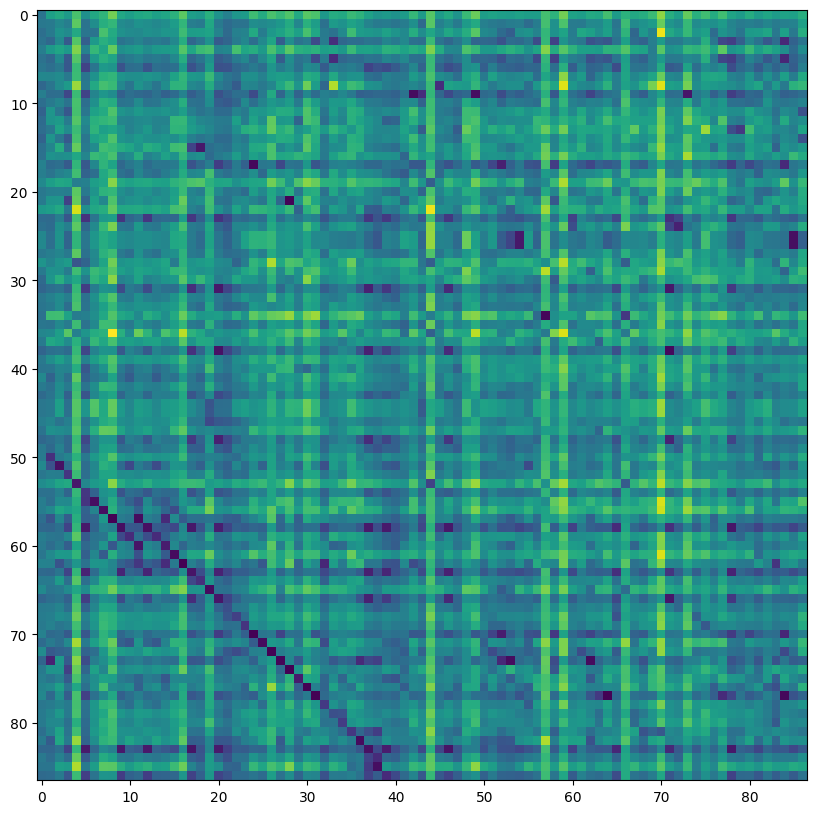

In [41]:
import gc
gc.collect()
tokens, sm = transcribe(model, data, language='ja')
print(tokens[0][len(tokenizer.sot_sequence):])
print(tokens[1][len(tokenizer.sot_sequence):])
plt.figure(figsize=(10, 10))
plt.imshow(sm.detach().numpy()[-1])

-88.54011206887662 34.0 77 31
(-88.54011206887662, 34.0, 2)


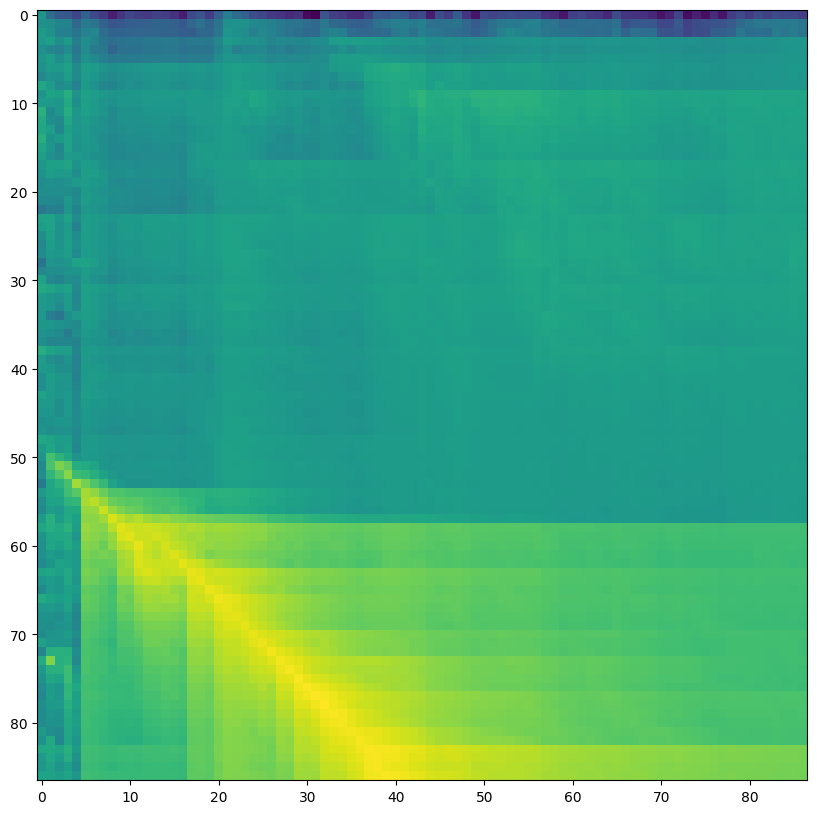

In [42]:
memo = {}
lol = -sm
fm, fl, fmi, fmj = -np.inf, 1, 0, 0
for i in range(lol.shape[-2]):
    for j in range(lol.shape[-1]):
        z = [memo.get(d, (0, 0, 0)) for d in [(i-1, j), (i, j-1), (i-1, j-1)]]
        scores, lens, dirs = np.array(list(zip(*z)))
        ns = scores + lol[0, i, j].detach().numpy()
        f = (ns/(lens+1)).argmax()
        memo[i, j] = (ns[f], lens[f]+1, f)
        if (memo[i, j][0]/memo[i, j][1]) > (fm/fl): fm, fl, fmi, fmj = memo[i, j][0], memo[i, j][1], i, j
            
print(fm, fl, fmi, fmj)
print(memo[fmi, fmj])
memo2 = [[0 for j in range(sm.shape[-1])] for i in range(sm.shape[-2])]
for i in range(sm.shape[-2]):
    for j in range(sm.shape[-1]):
        memo2[i][j] = memo[i, j][0]/memo[i, j][1]
plt.figure(figsize=(10, 10))
plt.imshow(np.array(memo2))

In [43]:
dirs = [(-1, 0), (0, -1), (-1, -1)]
ci, cj = fmi, fmj
l = memo[ci, cj][1]
trace = []
while l > 1:
    trace.append((ci, cj))
    di, dj = dirs[memo[ci, cj][2]]
    ci, cj = ci+di, cj+dj
    l -= 1
print(trace)

[(77, 31), (76, 30), (75, 29), (74, 28), (73, 27), (72, 26), (71, 25), (70, 24), (69, 23), (68, 22), (67, 21), (66, 20), (65, 19), (64, 18), (63, 17), (62, 16), (61, 15), (60, 14), (59, 13), (58, 12), (58, 11), (58, 10), (58, 9), (57, 8), (56, 7), (55, 6), (55, 5), (54, 5), (53, 4), (52, 3), (51, 2), (50, 1), (49, 1)]


In [44]:
f, s = np.array(list(zip(*trace)))[..., ::-1] + len(tokenizer.sot_sequence)
print(f)
print(s)
print(tokenizer.decode(np.array(tokens[0])[np.array(f)].tolist()))
print(tokenizer.decode(np.array(tokens[1])[np.array(s)].tolist()))
# f = tokens[0][len(tokenizer.sot_sequence):]
# s = tokens[1][len(tokenizer.sot_sequence):]

[52 53 54 55 56 57 58 58 59 60 61 61 61 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80]
[ 4  4  5  6  7  8  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34]
 統一歳、191927年、、、、7月25日、テート。 英語を必要とする時代は
統統一歳、、1927年、7年、7月25日、テート。 英語を必要とする時代は
